In [2]:
# Warning: usually don't do this kind of inclusion : using *, you 'merge' the namespaces
#          but in this case we actually want to mimic the imports as if they were imported here
from src.setup import *

from src.host import run_plink
from src import host
from src import common

# This prevents to restart the kernel whenever an external file is edited
%load_ext autoreload
%autoreload 2

# Comutation management
DATA_THINNING = False

# Introduction

**14'738'460 variants, 622 people.**

## Data processing plan

### Preprocessing 

1. Data thinning (if `DATA_THINNING == True`)
1. Create SNP map (SNP id and SNP position)

### Filtering
1. Remove missing values (variants)
1. Remove missing values (individuals)
1. Filter out rare variants and variants at Hardy-Weinberg disequilibrium

## Computation and path management

### Idea

Sometimes we don't want to re-do all the computations if the resulting data is already calculated. The features provided below aim to easily manage the paths and the computations:
1. A way of easily running shell commands
1. A dedicated function to easily run plink commands on the shell
1. A way of checking if the results already exist, and loading data if this is the case
    * Unless we specifically specify to re-do the calculations.

###### DOCUMENTATION 

Running shell commands and managing the outputs : https://janakiev.com/til/python-shell-commands/, https://www.pythonforbeginners.com/os/subprocess-for-system-administrators

### General principle

* `run_shell_command`: manage to run shell commands with a specific package (`subprocess`) that helps to manage the outputs. Returns a 2-tuple (stdout, stderr).
* `run_plink`: manage plink version, binary files location, output location, display errors, check if results already exist.

*NOTE: possible improvement: automatically find the file extension. Also, if the command results in several output files, we should check that all of them are present. So **be careful, we assume the user doesn't  only a fraction of the output files**.*

###### Workflow
1. Call `run_plink` command with the specific command (e.g. `--freq`), the input, the output and the file extension to look for (to avoid re-doing the computations). 
1. The function checks if the result already exist (needs the output and the extension resulting from the command)
    * already exists: display a message, abort the process (returns 2-tuple of empty strings). This occurs if `force==False` (which is the default value).
1. The command is runned with plink2 by default
1. The error messages are displayed (by default, `verbose_err=True`)
1. The outputs are returned as a tuple (stdout, stderr)

###### Modify behaviour

Change the boolean value defined in the first cell of this notebook.

### Path management

In [7]:
path_raw = PATH_HOST_RAW_PLINK_DATA
path_out = PATH_PLINK_DATA
file_prefix = 'host_geno'

if not os.path.exists(PATH_PLINK_LOG):
    os.system('mkdir '+PATH_PLINK_LOG)
    print("Created the directory", PATH_PLINK_LOG)

## Overview on raw data

### Files

In [3]:
path = PATH_HOST_RAW_DATA
!ls -lh $path

total 6.6G
-rwxr-xr-x 1 mazeller SV-BA4-unit  245  9 aoû 16:11 dictionary_wes_vcf.txt
-rw-r--r-- 1 mazeller SV-BA4-unit 2.2G 13 aoû 15:09 hbv_gilead_bcftools.bed
-rw-r--r-- 1 mazeller SV-BA4-unit 431M 13 aoû 15:09 hbv_gilead_bcftools.bim
-rw-r--r-- 1 mazeller SV-BA4-unit  18K 13 aoû 15:09 hbv_gilead_bcftools.fam
-rwxr-xr-x 1 mazeller SV-BA4-unit 2.2G  9 aoû 16:11 hbv_gilead.bed
-rwxr-xr-x 1 mazeller SV-BA4-unit 431M  9 aoû 16:11 hbv_gilead.bim
-rwxr-xr-x 1 mazeller SV-BA4-unit  18K  9 aoû 16:11 hbv_gilead.fam
-rw-r--r-- 1 mazeller SV-BA4-unit 1.4G 11 aoû 01:59 hbv_gilead.frq
-rw-r--r-- 1 mazeller SV-BA4-unit  930 11 aoû 01:59 hbv_gilead.log
-rw-r--r-- 1 mazeller SV-BA4-unit  13K 11 aoû 01:59 hbv_gilead.nosex
-rw-r--r-- 1 mazeller SV-BA4-unit  677 11 aoû 17:56 hbv_gilead_validate.log


Those are **plink binary files**. 

### Dictionnary of the data

In [4]:
!cat $path/dictionary_wes_vcf.txt

Info about WES_VCF by Ondrej.Podlaha@gilead.com on Dec 12 2018.

1. Human reference genome: GRCh37.87
2. Variant calling was performed using GATK (version nightly-2016-08-27-g667f78b; HaplotypeCaller)
3. dbSNP v138 was used by HaplotypeCaller
 


### Data integrity


In [5]:
run_plink('--validate', file=path_raw, out=path_out+file_prefix+'_validate', 
               extension='log', log_name='validate')
!cat $PATH_PLINK_LOG'validate.log'

run_plink: command '--validate', the file 'data/plink/host_geno_validate.log' already exists (force is set to False).
PLINK v2.00a2LM 64-bit Intel (31 Jul 2019)     www.cog-genomics.org/plink/2.0/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to data/plink/host_geno_validate.log.
Options in effect:
  --bfile data/raw/wes_plink/hbv_gilead_bcftools
  --out data/plink/host_geno_validate
  --validate

Start time: Tue Aug 13 17:31:45 2019
64232 MiB RAM detected; reserving 32116 MiB for main workspace.
Using up to 16 threads (change this with --threads).
622 samples (0 females, 0 males, 622 ambiguous; 622 founders) loaded from
data/raw/wes_plink/hbv_gilead_bcftools.fam.
14738460 variants loaded from data/raw/wes_plink/hbv_gilead_bcftools.bim.
Validating data/raw/wes_plink/hbv_gilead_bcftools.bed... done.
End time: Tue Aug 13 17:31:51 2019


## .bim file

This is an extended .map file, 
1. Chromosode code
1. Variant id (SNP)
1. Position in centimorgan
1. Baise-pair coordinate
1. ALT allele code
1. REF allele code

In [6]:
!head -10 $path_raw'.bim'

1	rs779258992	0	10146	A	AC
1	1:10400:C:T	0	10400	T	C
1	rs55998931	0	10492	T	C
1	rs58108140	0	10583	A	G
1	rs376342519	0	10616	C	CCGCCGTTGCAAAGGCGCGCCG
1	1:13012:A:G	0	13012	A	G
1	1:13054:C:T	0	13054	T	C
1	1:13250:G:T	0	13250	T	G
1	rs531730856	0	13273	C	G
1	rs538791886	0	13289	C	CCT


## Arbitrary thinning of the data

We use the plink2 `--thin <p>` option to **reduce the amount of data** (keep entries with probability p). We'll make sure that the code runs first. When everything works, we can simply set `DATA_THINNING = False`.

Management of the **data being taken into account**: we simply put `path_raw` to target the reduced data.

In [7]:
# We change the default raw data for subsequent analyses
if DATA_THINNING == True :
    file_prefix = 'host_reduced'
    run_plink("--thin 0.001 --make-bed", file=path_raw, out=path_out+file_prefix, 
              extension='bed', log_name='thinning')
    path_raw = path_out+file_prefix

## Note on plink

| Feature | Summary statistic | Inclusion criteria  |
|----------------------------|-----------|-----------|
| Missingness per individual | --missing | --mind N  |
| Missingness per marker     | --missing | --geno N  |
| Allele frequency           | --freq    | --maf N   |
| Hardy-Weinberg equilibrium | --hardy   | --hwe     |
| Mendel error rates         | --mendel  |  --me N M |

# SNP map generation

We create a Python dictionnary object and store it to easily convert the SNP references to their genome location. Those information are extracted from the `.bim` file.


In [8]:
# Create dictionnary
# Use custom manage_pickle function from common.py
def create_dict() :
    # Create DataFrame from .bim file
    df_bim = pd.read_csv(path_raw+'.bim', sep='\s+', header=None,
                         usecols=[0, 1, 3])
    df_bim.columns = ['#CHROM', 'SNP', 'COORD']
    print(df_bim.head(1))
    return dict(zip(df_bim['SNP'], df_bim['COORD']))

SNP_dic = common.manage_pickle(path=PATH_SNP_MAP, fun=create_dict)

manage_pickle: the file 'data/SNP_dict' has been loaded


# Missing values 

`.smiss` for sample-based missing data report:
* MISSING_CT: Number of missing hardcalls, not counting het haploids
* OBS_CT = Denominator (#males on chrY, otherwise #samples)
* F_MISS = Missing hardcall rate, not counting het haploids

###### Pandas - memory efficiency

When reading big files, one must provide to `pandas.read_csv` a map of the data types that are read to improve the memory usage:


In [75]:
dtype = {'F_MISS':float, 'ID':str, '#CHROM':str}

###### Run plink missing report

In [81]:
path_missing = path_out+file_prefix+'_missing'
o,e = run_plink("--missing", file=path_raw, out=path_missing, 
                extension='vmiss', log_name='missing', force=True)
df_miss_ind = pd.read_csv(path_missing+'.smiss', sep='\s+', 
                          usecols=['F_MISS'], dtype=dtype)
df_miss_var = pd.read_csv(path_missing+'.vmiss', sep='\s+', 
                          usecols=['#CHROM', 'ID', 'F_MISS'], dtype=dtype)

Running 'plink2 --bfile data/raw/wes_plink/hbv_gilead_bcftools --out data/plink/host_geno_clean_missing --missing '
Log written to 'data/plink/log/missing.log'


###### Plot function

In [82]:
def plot_missing(df_ind, df_var):
    fig, ax = plt.subplots(1, 2, figsize=(15, 3))
    sns.distplot(df_ind['F_MISS'], norm_hist=False, kde=False, ax=ax[0])
    ax[0].set_ylabel('number of individuals'); ax[0].set_xlabel('rate of missing variants');
    sns.distplot(df_var.F_MISS.dropna(), kde=False, norm_hist=False, ax=ax[1])
    ax[1].set_xlabel('rate of missing individuals'); ax[1].set_ylabel('number of variants');

We compute the rate of missing variants for each individual (this tells us about how to filter individuals out). We also plot the rate of missing individuals for each variants (this tells us about how to filter individuals out).

75.2% variants with missing rate of 100%


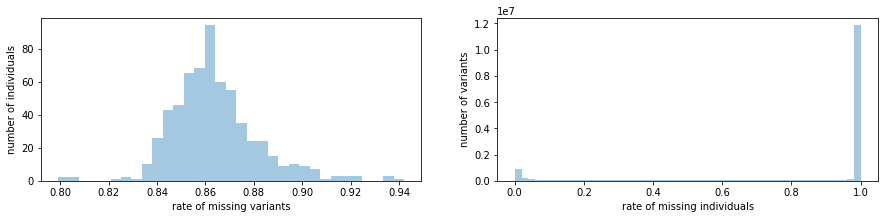

In [83]:
plot_missing(df_miss_ind, df_miss_var)
only_missing = df_miss_var.F_MISS[df_miss_var.F_MISS == 1.0].index
print("{:.3}% variants with missing rate of 100%"
      .format(len(only_missing)/df_miss_var.shape[0]*100))

###### First report of missing values

Looking at the plot on the right, we see the many variants have 100% of missing individuals. This is expected since the raw data has changed from the beginning. The provided data is now more adapted to exome sequencing data, where variants of poor sequencing quality (ex some intronic regions that are close to exonic regions) have been set to only missing values for each individual. 

This allows us to remove variants with 100% missingness before looking at the NaN's again, since missingness is biased here by those bad quality variants.

## Intermediate data

We first make a new look at the missing report *after* removing variants with 100% missingness (we can't simply drop the variants in the DataFrame since the plot of showing the rate of missing variants per individuals would be biased, we have to run the plink missing report again).

*Note: we actually would like to run `--geno 1.0`, but plink tests if the missingness is greater than the provided value (and not greater or equal). Thus we provide a value that is very close to 1.0.*

In [84]:
path_intermed=path_out+file_prefix+'_intermed'
o, e= run_plink('--geno 0.999999999 --make-bed', file=path_raw, out=path_intermed,
         extension='bed', force=True);

Running 'plink2 --bfile data/raw/wes_plink/hbv_gilead_bcftools --out data/plink/host_geno_clean_intermed --geno 0.999999999 --make-bed '


The log reports 3'661'936 remaining variants (11'076'524 removed).

## New plink missing report

At this point we have a dataset in which there is no variant with 100% missingness. We want to have an unbiased look at this new dataset:

Running 'plink2 --bfile data/plink/host_geno_intermed --out data/plink/host_geno_clean_missing --missing '
Log written to 'data/plink/log/missing.log'


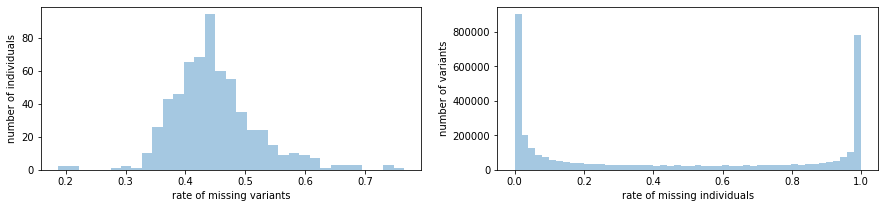

In [76]:
o,e = run_plink("--missing", file=path_intermed, out=path_missing, 
                extension='vmiss', log_name='missing', force=True)
df_miss_ind = pd.read_csv(path_missing+'.smiss', sep='\s+', 
                          usecols=['F_MISS'], dtype=dtype)
df_miss_var = pd.read_csv(path_missing+'.vmiss', sep='\s+', 
                          usecols=['#CHROM', 'ID', 'F_MISS'], dtype=dtype)
plot_missing(df_miss_ind, df_miss_var)

##### Report

If we carefully look at the plot on the left, we reassuringly observe that the histogram was **heavily shifted to the left** - i.e. to lower missing rates. This is expected since the raw data had many fully missing variants, which increased the missing rate of variants per individual. 

### Median missingness per chromosome

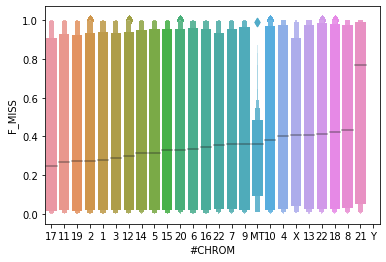

In [36]:
df_miss_chr = df_miss_var[['#CHROM', 'F_MISS']].groupby('#CHROM').median()
sns.boxenplot(x='#CHROM', y='F_MISS', data=df_miss_var,
             order=df_miss_chr.sort_values(by='F_MISS').index);

## Investigate missingness patterns w.r.t. some clinical variables

We want to make sure there are no patterns among variables such as sex, race, ... 

<br />

**TO BE DONE**

## Final missingness processing

Note: we need to separately filter missingness by individual and by variant, since plink first removes individuals (and we don't want that). Thus we first create a dataset with `--geno`, then with `--mind`.

In [8]:
# Managing paths and files
file_prefix = file_prefix + '_clean'
path_clean = path_out+file_prefix
path_clean_variants = path_clean+'_var'
path_clean_ind = path_clean+'_ind'

In [85]:
run_plink('--geno ' + str(THRESHOLD_MISSING_VARIANTS) + ' --make-bed', file=path_intermed, 
          out=path_clean_variants, extension='bed', log_name='filter_variants');
run_plink('--mind ' + str(THRESHOLD_MISSING_INDIVIDUALS) + ' --make-bed', 
          file=path_clean_variants, 
          out=path_clean_ind, extension='bed', log_name='filter_individuals');
run_plink('--missing', file=path_clean_ind, out=path_clean_ind,
         extension='vmiss', log_name='missing_final')
df_miss_ind = pd.read_csv(path_clean_ind+'.smiss', sep='\s+', 
                          usecols=['F_MISS'], dtype=dtype)
df_miss_var = pd.read_csv(path_clean_ind+'.vmiss', sep='\s+', 
                          usecols=['#CHROM', 'ID', 'F_MISS'], dtype=dtype)

run_plink: command '--geno 0.01 --make-bed', the file 'data/plink/host_geno_clean_var.bed' already exists (force is set to False).
run_plink: command '--mind 0.1 --make-bed', the file 'data/plink/host_geno_clean_ind.bed' already exists (force is set to False).
run_plink: command '--missing', the file 'data/plink/host_geno_clean_ind.vmiss' already exists (force is set to False).


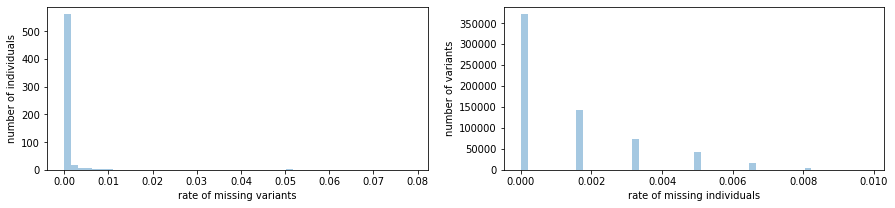

In [86]:
plot_missing(df_miss_ind, df_miss_var)
# Free memory
df_miss_ind = None
df_miss_var = None

The last log reports 676'575 remaining variants. 

# Minor allele frequencies

## plink1.9 report

* A1: minor allele (usually)
* A2: major allele (usually)
* MAF: frequency of A1

run_plink: command '--freq', the file 'data/plink/host_geno_clean_ind.frq' already exists (force is set to False).


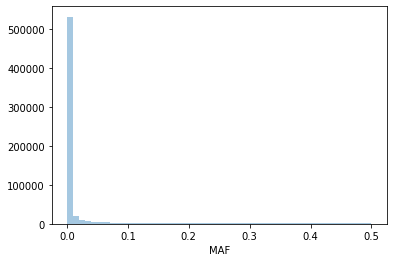

In [9]:
path_freq = path_clean_ind
run_plink('--freq', extension='frq', file=path_clean_ind, 
          out=path_clean_ind, plink2=False, log_name='freq_plink1');
df_freq = pd.read_csv(path_freq+".frq", sep="\s+")
df_freq.head(1)
sns.distplot(df_freq.MAF.dropna(), kde=False);

In [51]:
frequencies = [0.1, 0.05, 0.01, 0.005]
print("Percentage of variants to drop for different frequency thresholds:")
N = len(df_freq.MAF)
for f in frequencies :
    variants = df_freq.MAF[df_freq.MAF < f]
    print("{}\t{:.3}%".format(f, len(variants)/N*100))

Percentage of variants to drop for different frequency thresholds:
0.1	86.9%
0.05	84.5%
0.01	78.6%
0.005	74.7%


## plink2 report

In [3]:
dtype={'#CHROM':str, 'ID':str, 'REF':str, 'ALT':str, 'ALT_FREQS':float, 'OBS_CT':int}

run_plink: command '--freq', the file 'data/plink/host_geno_clean_ind.afreq' already exists (force is set to False).


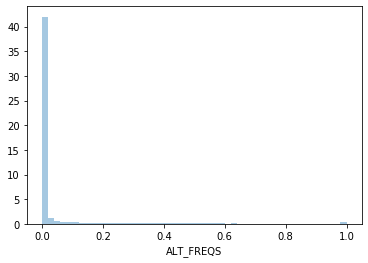

In [11]:
path_freq = path_clean_ind
run_plink('--freq', extension='afreq', file=path_clean_ind, out=path_freq, log_name='freq_plink2');
df_freq = pd.read_csv(path_freq+".afreq", sep="\s+", dtype=dtype)
sns.distplot(df_freq.ALT_FREQS.dropna(), kde=False, norm_hist=True);

In [54]:
df_freq = None

# Hardy-Weinberg equilibrium

* A1: Tested allele
* AX: Non-A1 alleles (comma-separated)
* HOM_A1_CT: Homozygous-A1 genotype count
* HET_A1_CT: Heterozygous-A1 genotype count
* TWO_AX_CT: number of NONmissing calls with no A1 copies
* O(HET_A1): Observed heterozygous-major frequency
* E(HET_A1): Expected heterozygous-major frequency
* P: Hardy-Weinberg equilibrium exact test p-value

In [55]:
path_hardy = path_clean_ind+'_hardy'
run_plink('--hardy', file=path_clean_ind, out=path_hardy, 
          extension='hardy', log_name='hardy');

Running 'plink2 --bfile data/plink/host_geno_clean_ind --out data/plink/host_geno_clean_ind_hardy --hardy '
Log written to 'data/plink/log/hardy.log'


In [56]:
df_hardy = pd.read_csv(path_hardy+'.hardy', sep="\s+")
df_hardy.head(3)

,#CHROM,ID,A1,AX,HOM_A1_CT,HET_A1_CT,TWO_AX_CT,O(HET_A1),E(HET_A1),P
0,1,1:14773:C:T,C,T,607,3,0,0.004918,0.004906,1.0
1,1,rs571121669,C,T,605,4,0,0.006568,0.006547,1.0
2,1,rs201013861,G,A,609,1,0,0.001639,0.001638,1.0


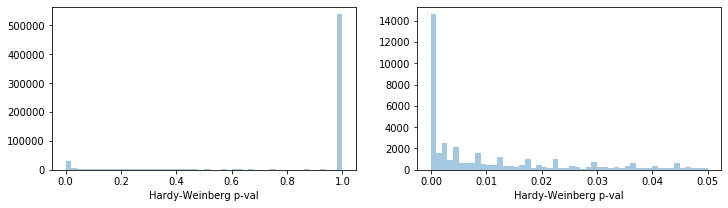

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))
sns.distplot(df_hardy.P, kde=False, ax=ax[0])
ax[0].set_xlabel('Hardy-Weinberg p-val');

sns.distplot(df_hardy.P[df_hardy.P <= 0.05], kde=False, ax=ax[1])
ax[1].set_xlabel('Hardy-Weinberg p-val');

In [59]:
#df_hardy['COORD'] = df_hardy.ID.map(SNP_dic)
#sns.scatterplot(x=df_hardy.COORD, y=df_hardy.P);

# Mendelian error rates

[Quote](http://zzz.bwh.harvard.edu/plink/summary.shtml#mendel):
> The `*.mendel` file contains all Mendel errors (i.e. one line per error); the `*.imendel` file contains a summary of per-individual error rates; the `*.fmendel` file contains a summary of per-family error rates; the `*.lmendel` file contains a summary of per-SNP error rates. 

In [60]:
run_plink("--mendel", extension='mendel', file=path_clean_ind,
          out=path_clean_ind, plink2=False, log_name='mendel');

Running 'plink --bfile data/plink/host_geno_clean_ind --out data/plink/host_geno_clean_ind --mendel '
treat these as missing.



Since there are **no trio**, there isn't any mendelian error rate to compute.

# Filter MAF and variants in HW disequilibrium

After this last step of filtering, we want to target to `path_clean`.

In [62]:
run_plink("--maf 0.01 --hwe 1e-6 --make-bed", file=path_clean_ind, out=path_clean,
          extension='bim', force=True, log_name='filter_maf_hardy');

Running 'plink2 --bfile data/plink/host_geno_clean_ind --out data/plink/host_geno_clean --maf 0.01 --hwe 1e-6 --make-bed '
Log written to 'data/plink/log/filter_maf_hardy.log'


# PCA pre-processing

## Find intersecting individuals

We first want to include only individuals that are in all the three datasets. We run the custom function `common.find_individuals`. We'll later use the command `--keep-fam <file>` of plink to filter the individuals. We could actually use `--keep <file>`, but in our case those two ids are the same (and the file for the former option has to have two columns).

[Quote](https://www.cog-genomics.org/plink/1.9/filter):
> --keep accepts a space/tab-delimited text file with family IDs in the first column and within-family IDs in the second column, and removes all unlisted samples from the current analysis. --remove does the same for all listed samples.
>
>Similarly, --keep-fam and --remove-fam accept text files with family IDs in the first column, and keep or remove entire families.

In [9]:
common.find_individuals(fam=PATH_HOST_CLEAN_DATA,
                        clinical=PATH_CLINICAL_DATA,
                        viral=PATH_VIRAL_DATA, 
                        output_path=PATH_INTERSECTING_INDIVIDUALS)
# Write them into a file that can be read by the --keep command of plink
#with open(PATH_INTERSECTING_INDIVIDUALS, 'w') as file:
#    file.write(df_inds[ID_IGM_CLINICAL_DF].to_csv(header=False, index=False))

725 in clinical
789 in viral
611 in host genotypes
Viral and clinical ids:	611 in intersection, 725 in union
Geno and clinical ids :	724 in intersection, 790 in union
Global intersection : 610
Written to data/individuals/intersecting_ids


## Asian individuals

We aim here to generate a dataset with only asian people with excluded X, Y and chromosome 6. We first compute the list of asian individuals.

In [5]:
# First generate the list of individuals that are part of the 'asian race'
common.find_individuals(fam=PATH_HOST_CLEAN_DATA,
                        clinical=PATH_CLINICAL_DATA,
                        viral=PATH_VIRAL_DATA, 
                        output_path=PATH_INDIVIDUALS_ASIAN,
                        criteria = ('RACE', 'ASIAN'), verbose=False)

Written to data/individuals/asians (440 individuals)


/home/mazeller/.local/lib/python3.6/site-packages/pandas/core/indexes/base.py:183: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return cls.__new__(cls, **d)


# Phenotypes and covariates

## Phenotypes

We now want to include some external phenotype data, i.e. the ones in the clinical data. From the [documentation of plink1.9](https://www.cog-genomics.org/plink/1.9/input#pheno) :
> --pheno causes phenotype values to be read from the 3rd column of the specified **space- or tab-delimited file**, instead of the .fam or .ped file. The first and second columns of that file must contain family and within-family IDs, respectively.
>
> In combination with --pheno, --mpheno lets you use the (n+2)th column instead of the 3rd column, while --pheno-name lets you select a column by title. (In order to use --pheno-name, there must be a header row with first two entries 'FID' and 'IID'.)

More documentation:
> To specify an alternate phenotype for analysis, i.e. other than the one in the `*.ped` file (or, if using a binary fileset, the `*.fam` file), use the --pheno option
> 
> If an individual is in the original file but not listed in the alternate phenotype file, that person's phenotype will be set to missing. If a person is in the alternate phenotype file but not in the original file, that entry will be ignored. The order of the alternate phenotype file need not be the same as for the original file. If the phenotype file contains more than one phenotype, then use the `--mpheno N` option to specify the Nth phenotype is the one to be used: 
>
> Alternatively, your alternate phenotype file can have a header row, in which case you can use variable names to specify which phenotype to use. If you have a header row, the first two variables must be labelled FID and IID. All subsequent variable names cannot have any whitespace in them.
>
> Finally, if there is more than one phenotype, then for basic association tests, it is possible to specify that all phenotypes be tested, sequentiall [...]. You might want to use the `--pfilter` command in this case, to only report results with a p-value less than a certain value, e.g. `--pfilter 1e-3`.
>
> **Warning: Currently, all phenotypes must be numerically coded, including missing values, in the alternate phenotype file. The default missing value is -9, change this with `--missing-phenotype`, but it must be a numeric value still (in contrast to the main phenotype in the PED/FAM file).**

### Create plink-readable file

As shown above, the file should begin with a header row indicating the column names (we will want to select the phenotypes by their names). All entries must begin with FID and IID, but we can add any number of extra columns (at least 1). Values can be separated by (spaces or) *tabs*.

In [31]:
# Create a phenotype file from the clinical DataFrame
# Using custom function
phenotype_columns = ['BASELINE_BMI']
common.convert_to_plink_phenotype(path=PATH_CLINICAL_DATA,
                                  out=PATH_CLINICAL_PLINK_PHENOTYPE,
                                  id_col_name='IGM_ID', cols=phenotype_columns)

Successfully written 'data/plink/pheno.txt'


## Covariates

[Doc](http://zzz.bwh.harvard.edu/plink/data.shtml#covar): 
> The covariate file should be formatted in a similar manner to the phenotype file. If an individual is not present in the covariate file, or if the individual has a missing phenotype value (i.e. -9 by default) for the covariate, then that individual is set to missing (i.e. will be excluded from association analysis).
>
> To select a particular subset of covariates, use one of the following commands, which either use numbers or names (i.e. if a header row exists in the file), 
>         
>        plink --file mydata --covar c.txt --covar-number 2,4-6,8 
>        plink --file mydata --covar c.txt --covar-name AGE,BMI-SMOKE,ALC 
>
> To output a new covariate file, possibly with categorical variables downcoded to binary dummy variables use the --write-covar option as described [here](http://zzz.bwh.harvard.edu/plink/dataman.shtml#wrtcov).
>
> *Note: Not all commands accept covariates, and PLINK will not always give you an error or warning. The basic association (--assoc, --mh, --model, --tdt, --dfam, and --qfam) do **not** accept covariates, neither do the basic haplotype association methods (--hap-assoc, --hap-tdt). Among the commands that do are --linear, --logistic, --chap and --proxy-glm. Also --gxe accepts a single covariate only (the others listed here accept multiple covariates).*

***
***
<br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br />